In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

## Radius vs Spin in the Original (Raw) Dataset

### Is the hockey stick shape of the spin-size plot physical or is it a typo coming from calculating the halfmass radius?

### <font color='darkred'>  Conclusion: The hockey-stick shape of the spin-size plot is inherent in the dataset; it comes from the Rdisk-spin relation (most probably galaxies below a given spin, say 0.025-ish, are assigned a small range of sizes, 0-2 kpc)

In [3]:
# original (raw) dataset, not normalized, no halfmass radius column present
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv')

In [5]:
df_log_mass_filtered_v5.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction
0,130136.002554,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19
1,541275.017895,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01


In [6]:
df_log_mass_filtered_v5.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRedshift',
 'GalpropRfric',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'GalpropX',
 'GalpropVx',
 'GalpropY',
 'GalpropVy',
 'GalpropZ',
 'GalpropVz',
 'HalopropC_nfw',
 'HalopropMaccdot_metal',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMaccdot_reaccreate_metal',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMdot_eject',
 'HalopropMdot_eject_metal',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMst

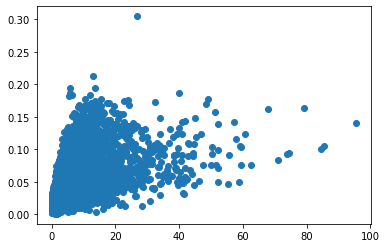

In [29]:
rbulge_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRbulge'] # 3D half-mass radius of bulge

rdisk_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRdisk'] # 3D half-mass radius of disk

rhalo_raw = df_log_mass_filtered_v5.loc[:, 'GalpropRhalo'] # halo virial radius

spin_raw = df_log_mass_filtered_v5.loc[:, 'HalopropSpin']

halfrad =  df_log_mass_filtered_v5.loc[:, 'GalpropHalfRadius'] # Half-radius as calculated by the function

plt.scatter(rdisk_raw, spin_raw)
plt.show()

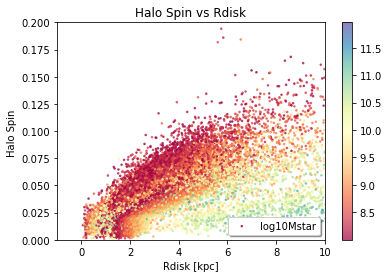

In [24]:
plt.scatter(rdisk_raw, spin_raw,
            c = np.log10(df_log_mass_filtered_v5.loc[:, 'GalpropMstar']),  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'log10Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-1,10, 0.0,0.2])
plt.title('Halo Spin vs Rdisk')
plt.xlabel('Rdisk [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()

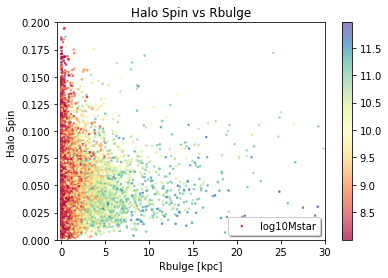

In [36]:
plt.scatter(rbulge_raw, spin_raw,
            c = np.log10(df_log_mass_filtered_v5.loc[:, 'GalpropMstar']),  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'log10Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.5,30, 0.0,0.2])
plt.title('Halo Spin vs Rbulge')
plt.xlabel('Rbulge [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()

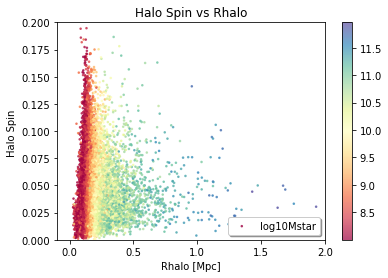

In [22]:
plt.scatter(rhalo_raw, spin_raw,
            c = np.log10(df_log_mass_filtered_v5.loc[:, 'GalpropMstar']),  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'log10Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.1,2, 0.0,0.2])
plt.title('Halo Spin vs Rhalo')
plt.xlabel('Rhalo [Mpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()

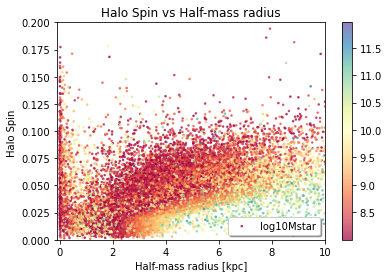

In [32]:
plt.scatter(halfrad, spin_raw,
            c = np.log10(df_log_mass_filtered_v5.loc[:, 'GalpropMstar']),  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label = 'log10Mstar') #,label= label, vmin=-2, vmax=1.0)
# plt.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
plt.axis([-0.1,10, 0.0,0.2])
plt.title('Halo Spin vs Half-mass radius')
plt.xlabel('Half-mass radius [kpc]')
plt.ylabel('Halo Spin ')
plt.legend(loc='lower right' , shadow=True)
plt.colorbar()
# plt.savefig('Spin_vs_size_disks_samplesize14000.jpeg', dpi=500)
plt.show()